In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.functional as F
import json
from tqdm.auto import tqdm, trange
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
torch.cuda.empty_cache()

In [4]:
def conv3x3(in_ch, out_ch, stride=1):
    """3x3 convolution with padding."""
    return nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=stride, padding=1)

def conv1x1(in_ch, out_ch, stride=1):
    """1x1 convolution."""
    return nn.Conv2d(in_ch, out_ch, kernel_size=1, stride=stride)

class ResidualBlockWithStride(nn.Module):
    """Residual block with a stride on the first convolution.

    Args:
        in_ch (int): number of input channels
        out_ch (int): number of output channels
        stride (int): stride value (default: 2)
    """

    def __init__(self, in_ch, out_ch, stride=2, inplace=False):
        super().__init__()
        self.conv1 = conv3x3(in_ch, out_ch, stride=stride)
        self.leaky_relu = nn.LeakyReLU(inplace=inplace)
        self.conv2 = conv3x3(out_ch, out_ch)
        self.leaky_relu2 = nn.LeakyReLU(negative_slope=0.1, inplace=inplace)
        if stride != 1:
            self.downsample = conv1x1(in_ch, out_ch, stride=stride)
        else:
            self.downsample = None

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.leaky_relu(out)
        out = self.conv2(out)
        out = self.leaky_relu2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out = out + identity
        return out

class IntraPredictorModel(nn.Module):
    def __init__(self, inplace=False):
        super().__init__()
        self.in_ch = 128
        self.h_ch = 16

        self.global_h = 9
        self.global_w = 16

        self.inner_dim = 128
    
        self.res_block = ResidualBlockWithStride(self.in_ch, self.h_ch, stride=2)
        self.global_pooling = nn.AdaptiveAvgPool2d((self.global_w, self.global_h))
        self.linear1 = nn.Linear(self.global_h * self.global_w * self.h_ch, self.inner_dim)
        self.leaky_relu = nn.LeakyReLU(inplace=inplace)
        # self.lstm = nn.LSTM(self.inner_dim, self.inner_dim, 1, batch_first=False, dropout=0.2)
        self.linear2 = nn.Linear(self.inner_dim, 1)
        self.softmax = nn.Sigmoid()

    def forward(self, x):
        x = self.res_block(x)
        x = self.global_pooling(x)
        x = x.view(x.size(0), -1)
        x = self.linear1(x)
        x = self.leaky_relu(x)
        # x, _ = self.lstm(x)
        x = self.linear2(x)
        x = self.softmax(x)

        return x

In [4]:
with open("../media/syntetic-low/predictor_dataset_0/reference_points.json", "r") as f:
    intra_ref_points = json.load(f)

In [5]:
def enrich_ref_points(ref_points, distance=64):
    enriched = []
    all_points = set(ref_points)
    for idx in range(1, len(ref_points)):
        prev = ref_points[idx - 1]
        curr = ref_points[idx]
        all_points.update(np.arange(prev, curr, distance, dtype=int))
    
    return sorted([int(p) for p in all_points])

In [6]:
all_ref_points = enrich_ref_points(intra_ref_points)

```python
frames_data = {
    "intra_frames": intra_ref_points,
    "refresh_frames": all_ref_points
}

with open("../media/syntetic/predictor_dataset_0/frames.json", "w") as f:
    json.dump(frames_data, f)
```

### Train loop with loaded inputs. 

Epochs should consist of going through the whole set of batches.
Batch is consisting of frames (contexts of those frames) within the range of the two neighboring reference points (`all_ref_points`).
Loss function is cross entropy between frame types (0 - non-reference, 1 - reference). Cross entropy should be weighted, so that the punishment for not guessing the reference frame is higher.

In [7]:
loaded = torch.load("../output/predictor_contexts/contexts.pth")

In [8]:
loaded = torch.cat([torch.zeros_like(loaded[0]).unsqueeze(0), loaded], dim=0).to(torch.float16)

In [9]:
ref_frame_weight = 3

dist_alpha = 1
dist_beta = 1.2
non_ref_distribution = torch.distributions.Beta(dist_alpha, dist_beta)

def criterion_for_batch(batch_size, device='cpu'):
  weights = (torch.exp(non_ref_distribution.log_prob(torch.linspace(0, 1, batch_size - 1))) / (dist_alpha * 2)) + 0.5
  weights = torch.cat([weights, torch.tensor([ref_frame_weight])]) / ref_frame_weight
  return nn.BCELoss(weight=weights).to(device)

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = IntraPredictorModel().to(torch.float32).to(device)
loaded = loaded.to(torch.float32).to(device)

/workspace/DCVC_Dynamic_Intra_Period/venv/lib/python3.10/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [11]:
torch.cat([
  criterion_for_batch(100, device).weight[(torch.ones(100).to(device) / 100).multinomial(num_samples=5, replacement=True)], 
  criterion_for_batch(100, device).weight[-1].unsqueeze(0)
  ])

tensor([0.3076, 0.2846, 0.3597, 0.3371, 0.3448, 1.0000], device='cuda:0')

In [12]:
def train(model, epochs, device, lr=1e-3):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    losses = []

    for epoch in trange(epochs):
        for idx in range(1, len(all_ref_points)):
            start_frame = max(all_ref_points[idx - 1] - 1, 1) # Skip first intra frame from sequence
            end_frame = all_ref_points[idx] - 1

            batch_size = end_frame - start_frame + 1
            criterion = criterion_for_batch(batch_size, device)
            batch = loaded[idx:idx + batch_size - 1]

            batch_index = (torch.ones(batch_size).to(device) / batch_size).multinomial(num_samples=5, replacement=True)

            print(batch_index)

            batch = torch.cat([batch[batch_index], loaded[idx + batch_size - 1].unsqueeze(0)], dim = 0)
            criterion.weight = torch.cat([criterion.weight[batch_index], criterion.weight[-1].unsqueeze(0)])

            print(batch.size())

            optimizer.zero_grad()
            output = model(batch)
            true_labels = torch.cat([torch.zeros(5), torch.ones(1)]).to(torch.float32).to(device)

            print("{} {}".format(output.squeeze(1).size(), true_labels.size()))
            print("{}\n{}".format(output.squeeze(1), true_labels))

            loss = criterion(output.squeeze(1), true_labels)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

        clear_output(wait=True)
        plt.figure(figsize=(15,5))
        plt.plot(losses, label="Weighted BCELoss", linewidth=0.3)
        plt.grid(True)
        plt.legend()
        plt.axhline(0, color="k", linestyle="--")
        plt.axvline(0, color="k", linestyle="--")
        plt.show()
    
    return losses

In [13]:
l = train(model, 400, device, lr = 1e-3)

  0%|          | 0/400 [00:00<?, ?it/s]

tensor([30,  3,  2, 56, 61], device='cuda:0')
torch.Size([6, 128, 68, 120])
torch.Size([6]) torch.Size([6])
tensor([0.5129, 0.5120, 0.5111, 0.5107, 0.5105, 0.5105], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([0., 0., 0., 0., 0., 1.], device='cuda:0')
tensor([24, 11, 30, 31,  2], device='cuda:0')
torch.Size([6, 128, 68, 120])
torch.Size([6]) torch.Size([6])
tensor([0.5019, 0.4962, 0.4944, 0.4931, 0.4925, 0.4927], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([0., 0., 0., 0., 0., 1.], device='cuda:0')
tensor([45,  0, 30, 10, 13], device='cuda:0')
torch.Size([6, 128, 68, 120])
torch.Size([6]) torch.Size([6])
tensor([0.4885, 0.4748, 0.4701, 0.4683, 0.4683, 0.4680], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([0., 0., 0., 0., 0., 1.], device='cuda:0')
tensor([ 9,  1,  2,  9, 10], device='cuda:0')
torch.Size([6, 128, 68, 120])
torch.Size([6]) torch.Size([6])
tensor([0.4672, 0.4475, 0.4401, 0.4372, 0.4369, 0.4375], device='cuda:0',
       grad_fn=<S

../aten/src/ATen/native/cuda/IndexKernel.cu:92: operator(): block: [78,0,0], thread: [32,0,0] Assertion `-sizes[i] <= index && index < sizes[i] && "index out of bounds"` failed.
../aten/src/ATen/native/cuda/IndexKernel.cu:92: operator(): block: [78,0,0], thread: [33,0,0] Assertion `-sizes[i] <= index && index < sizes[i] && "index out of bounds"` failed.
../aten/src/ATen/native/cuda/IndexKernel.cu:92: operator(): block: [78,0,0], thread: [34,0,0] Assertion `-sizes[i] <= index && index < sizes[i] && "index out of bounds"` failed.
../aten/src/ATen/native/cuda/IndexKernel.cu:92: operator(): block: [78,0,0], thread: [35,0,0] Assertion `-sizes[i] <= index && index < sizes[i] && "index out of bounds"` failed.
../aten/src/ATen/native/cuda/IndexKernel.cu:92: operator(): block: [78,0,0], thread: [36,0,0] Assertion `-sizes[i] <= index && index < sizes[i] && "index out of bounds"` failed.
../aten/src/ATen/native/cuda/IndexKernel.cu:92: operator(): block: [78,0,0], thread: [37,0,0] Assertion `-size

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


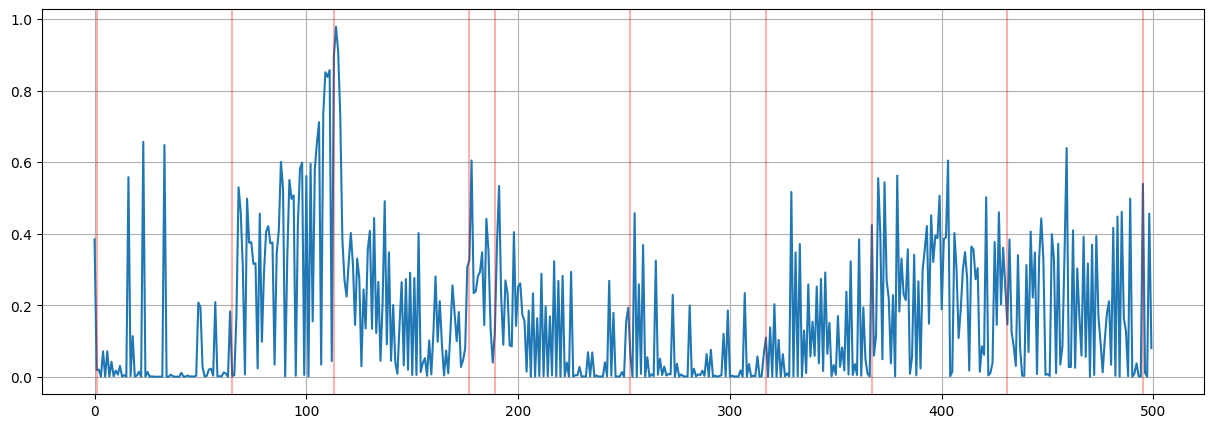

In [ ]:
with torch.no_grad():
  result = model(loaded[:500]).detach().cpu()
  plt.figure(figsize=(15,5))
  plt.grid(True)
  plt.plot(torch.arange(0, 500), result)
  for idx in all_ref_points:
    if idx <= 500:
      plt.axvline(idx, c = 'r', alpha = 0.3)